### Predgovor
Ova vježba sastoji se od teoretskog i praktičnog dijela. Bez adekvatnog teorijskog razumijevanja, izvedba vježbe biti će značajno izazovnija.

Predlažemo da napravite kopiju ove bilježnice na svoj Colab profil i tamo riješite vježbu. Ne zaboravite uključiti GPU akceleraciju (Runtime->Change runtime type->GPU->Save). \

U slučaju nejasnoća javite se na anja.delic@fer.hr.

# 4. Laboratorijska vježba - generativno modeliranje

Jedan od glavnih katalizatora u razvoju modernog računalnog vida jest dostupnost velikih skupova podataka. Iako su skupovi podataka lako dostupni, proces koji generira podatke je često nepoznat. Cilj ove laboratorijske vježbe jest pokušati aproksimirati proces koji generira dani skup podataka.


## Teorijska podloga generativnom modeliranju

Krenuti ćemo od bolje definicije zadatka.
Pretpostavimo postojanje skupa podataka $D=\{\mathbf{x}_i\}_{i=1}^N$ koji je nastao uzorkovanjem nepoznate distribucije $P_D(\underline{\mathbf{x}})$. Nadalje, pretpostavimo da je svaki primjer $\mathbf{x}_i$ dobiven nezavisnim uzorkovanjem. Naš cilj je aproksimirati nepoznatu distribuciju podataka $P_D(\underline{\mathbf{x}})$ poznatim modelom $P_\theta(\underline{\mathbf{x}})$.
S obzirom da su naši podaci često u kontinuirani ($\underline{\mathbf{x}}$ je kontinuirana slučajna varijabla) baviti ćemo se modeliranjem gustoća vjerojatnosti $p_D(\underline{\mathbf{x}})$ i $p_\theta(\underline{\mathbf{x}})$.

**Problem 1.:** Kako poravnati nepoznati $p_D(\underline{\mathbf{x}})$ i poznati $p_\theta(\underline{\mathbf{x}})$?



U teoriji vjerojatnosti, različitost između dvije distribucije $P(\underline{x})$ i $Q(\underline{x})$ se mjeri pomoću f-divergencije. Jedna od najčešćih mjera iz obitelji f-divergencija je KL-divergencija. KL-divergenciju za kontinuirane slučajne varijable definiramo kao:
$$
\mathrm{KL}(P, Q) = \int_{-\infty}^{+\infty} p(x) \ln\frac{p(x)}{q(x)} dx.
$$
$p$ i $q$ su pripadajuće gustoće vjerojatnosti.

KL-divergencije između distribucije podataka i distribucije modela je primamljiv gubitak za naš optimizacijski postupak. Može se pokazati da je minimizacija KL divergencije između distribucije podataka i distribucije modela ekvivalentna minimizaciji negativne log-izglednosti skupa podataka za učenje:
$$
\underset{\theta}{\mathrm{min}} \, \mathrm{KL}(p_D, p_\theta) \simeq \underset{\theta}{\mathrm{min}} \, -\mathbb{E}_{\mathbf{x} \in D} \;\;  [\ln p_\theta(\mathbf{x})]
$$

**Zadatak 1.**: Dokažite navedenu tvrdnju.

Dokaz:
$$
\, \mathrm{KL}(p_D, p_\theta) =   \int_{-\infty}^{+\infty} p_D(x) \ln\frac{p_D(x)}{p_\theta(x)} dx
$$
$$
\, \mathrm{KL}(p_D, p_\theta) =  \int_{-\infty}^{+\infty} p_D(x) \ln p_D(x) dx - \int_{-\infty}^{+\infty} p_D(x) \ln p_\theta(x) dx .
$$
$$
\, \mathrm{KL}(p_D, p_\theta) =  H(p_D) - E(\ln p_\theta(x) dx)
$$
$$
\underset{\theta}{\mathrm{min}} \, \mathrm{KL}(p_D, p_\theta)  = \underset{\theta}{\mathrm{min}} \, ( \int_{-\infty}^{+\infty} p_D(x) \ln p_D(x) dx - \int_{-\infty}^{+\infty} p_D(x) \ln p_\theta(x) dx )
$$
$$
\underset{\theta}{\mathrm{min}} \, \mathrm{KL}(p_D, p_\theta) =  \underset{\theta}{\mathrm{min}} \, (H(p_D) - E(\ln p_\theta(x) dx))
$$
A kako je entropija od p konstanta, minimum degradira samo u drugi član :
$$
\underset{\theta}{\mathrm{min}} \, \mathrm{KL}(p_D, p_\theta) =  \underset{\theta}{\mathrm{min}} \, (- E(\ln p_\theta(x) dx))
$$

**Problem 2.**: Definicija modela $p_\theta$.

Naš sljedeći korak je definirati model $p_\theta$. Upravo po definiciji  $p_\theta$ razlikujemo različite generativne modele.
Na primjer autoregresivna faktorizacija modela dovodi do autoregresijskih modela, dok modeliranje nenormalizirane distribucije dovodi do energijskih modela. U ovoj vježbi se fokusiramo  na vrstu generativnih modela koje nazivamo normalizirajući tokovi. Normalizirajući tok $p_\theta$ definiramo pomoću formule za zamjenu varijabli distribucije.

Pretpostavimo da su $\underline{\mathbf{x}}$ i $\underline{\mathbf{z}}$ dvije kontinuirane slučajne varijable. Pretpostavimo da bijekcija $f$ mapira realizacije slučajne varijable $\underline{\mathbf{x}}$ u realizacije od $\underline{\mathbf{z}}$, to jest $\mathbf{z} = f(\mathbf{x})$. S obzirom da je $f$ bijekcija vrijedi i obrat $\mathbf{x} = f^{-1}(\mathbf{z})$. Formulu za zamjenu varijabi distribucije definiramo kao:
$$
 p(\mathbf{x}) = q(\mathbf{z}) \left| \mathrm{det} \frac{\partial \mathbf{z}}{ \partial \mathbf{x}} \right|, \quad \mathbf{z} = f(\mathbf{x})
$$
$\frac{∂ \mathbf{z}}{ ∂ \mathbf{x}}$ predstavlja Jakobijan funkcije $f$ za $\textbf{x}$. det predstavlja determinantu. $|\cdot|$ predstavlja apsolutnu vrijednost.
To jest, drugi član umnoška odgovara apsolutnoj vrijednosti determinante Jakobijana transformacije $f$.

Formulu za zamjenu varijabli ćemo iskoristiti za izgradnju okvira koji nam omogućava implementaciju dubokog generativnog modela.
Ideja je jednostavna, distribuciju $q(\mathbf{z})$ možemo predefinirati (npr. kao Gaussovu distribuciju). Tada nam je jedina nepoznanica bijekcija $f$ koju možemo parametrizirati s $\theta$ te naučiti optimizacijskim postupkom.


Prisjetimo se sljedećih teorema:
1. kompozicija bijekcija je bijekcija, tj $f$ možemo raspisati kao $f = f_1 ∘ f_2 ∘ f_3 ∘ \dots \circ f_K$.
2. pravilo ulančavanja: $\frac{∂ z_3}{ ∂ z_1} = \frac{∂ z_3}{ ∂ z_2}\frac{∂ z_2}{ ∂ z_1} $
3. determinanta umnoška dviju kvadratnih matrica istog reda jednaka je umnošku determinanti svake matrice (Binet-Cauchyjev teorem)
4. Apsolutna vrijednost umnoška dva realna broja je jednaka umnošku apsolutnih vrijednosti: $|a\cdot b| = |a|\cdot |b|$

Bijekciju $f$ možemo promatrati kao kompoziciju funkcija, gdje svaka funkcija $f_i$ prima varijablu $z_{i-1}$ i računa varijablu $z_i$.
Ako uzmemo u obzir prethodno spomenute teoreme, dolazimo do sljedeće formulacije:
$$
 p_\theta (\mathbf{x}) = q(\mathbf{z}_K) \prod_{k=1}^K \left| \mathrm{det} \frac{\partial \mathbf{z}_{k} }{ \partial \mathbf{z}_{k-1}} \right|, \quad \mathbf{z}_{k} = f_{\theta_k}(\mathbf{z}_{k-1}),
$$
gdje je $\mathbf{z}_{0} = \mathbf{x}$.
$q(\mathbf{z}_K)$ može biti proizvoljna distribucija pa je definiramo kao $q(\mathbf{z}_K):= \mathcal{N}(\mathbf{z}_K; 0, \mathrm{I})$.

**Zadatak 2.** Krenuvši od općenite formule za zamjenu varijabli izvedite izraz za normalizirajući tok.

Izvod:
$$
p(\mathbf{x}) = q(\mathbf{z}_K) \left| \mathrm{det} \frac{\partial f(\mathbf{x})}{ \partial \mathbf{x}} \right|
$$
$$
| z = f(x) , \partial f(\mathbf{x}) =\partial z |
$$
$$
= q(\mathbf{z}_K) | \mathrm{det} \frac{\partial \mathbf{z}_{k} }{ \partial \mathbf{z}_{k-1}}| | \mathrm{det} \frac{\partial \mathbf{z}_{k-1} }{ \partial \mathbf{z}_{k-2}}| | \mathrm{det} \frac{\partial \mathbf{z}_{k-2} }{ \partial \mathbf{z}_{k-3}}| ... | \mathrm{det} \frac{\partial \mathbf{z}_{1} }{ \partial \mathbf{x}}|
$$
$$
= q(\mathbf{z}_K) \prod_{k=1}^K \left| \mathrm{det} \frac{\partial \mathbf{z}_{k} }{ \partial \mathbf{z}_{k-1}} \right|
$$
$$
| z = f(x) , \mathbf{x} = f^{-1}(\mathbf{z})|
$$
$$
= q(\mathbf{z}) \left| \mathrm{det} \frac{\partial f^{}(\mathbf{x})}{ \partial \mathbf{x}} \right|
$$
$$
= q(\mathbf{ f(x) }) \left| \mathrm{det} \frac{\partial f^{}(\mathbf{x})}{ \partial \mathbf{x}} \right|
$$

Spomenimo još da nas općenito zanima logaritam gustoće vjerojatnosti pa pišemo:
$$
 \ln p_\theta (\mathbf{x}) = \ln q(\mathbf{z}_K) +\sum_{k=1}^K \ln \left| \mathrm{det} \frac{\partial \mathbf{z}_{k} }{ \partial \mathbf{z}_{k-1}} \right|, \quad \mathbf{z}_{k} = f_{\theta_k}(\mathbf{z}_{k-1}), \tag{1}
$$

Ostala nam je još jedna nepoznanica, a to je dizajn funkcija $f_k$,  $k=1,...,K$.
Dizajn funkcije f ovisi o podacima koje modeliramo. Razmislite kako biste bijekciju modelirali kao gradivni blok dubokog modela.

## Modeliranje 2D skupa podataka normalizirajućim tokom

**Problem 3.** Modeliranje 2D skupa podatka.

In [ ]:
import torch
import random
import numpy as np
import torch.nn as nn

np.random.seed(0)
random.seed(0)
torch.manual_seed(0)

import matplotlib.pyplot as plt

In [ ]:
class GaussianMixture2DDataset:
    def __init__(self, num_samples, n_comp=2, loc=torch.zeros(2,2), scale=torch.ones(2,2), pi=(torch.ones(2)/2)):
        samples_per_component = (pi * num_samples).long()
        self.samples = torch.cat([torch.randn(samples_per_component[i],2) * scale[i] + loc[i] for i in range(n_comp)], 0)

    def __getitem__(self, idx):
        return self.samples[idx]

Promotrimo sljedeći skup podataka. Pretpostavimo da nam je dostupan samo skup podataka $D$. Cilj nam je aproksimirati distribuciju podataka $p_D$ pomoću normalizirajućeg toka.

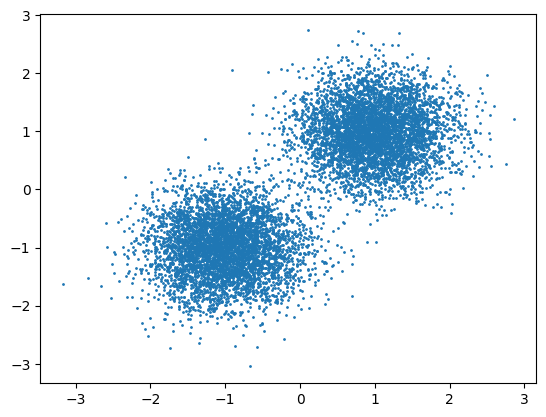

In [ ]:
D = GaussianMixture2DDataset(9999, loc=torch.tensor([[-1, -1], [1,1]]), scale=torch.tensor([[0.5, 0.5], [0.5,0.5]])).samples
plt.scatter(D[:, 0], D[:, 1], 1)
plt.show()

In [ ]:
D.shape

torch.Size([9998, 2])

S obzirom da modeliramo 2D skup podatka, zanimaju nas funkcije s domenom $\mathbb{R}^2$ i kodomenom $\mathbb{R}^2$ koje imaju inverz.
Definiramo sljedeći implementacijski ovir:

In [ ]:
from abc import ABC, abstractmethod
class _Bijection(nn.Module, ABC):
    def __init__(self):
        super(_Bijection, self).__init__()
    @abstractmethod
    def forward(self, x):
        pass
    @abstractmethod
    def inverse(self, z):
        pass

Funkcija `forward` implementira unaprijedni prolaz kroz sloj i na izlazu vraća transformirani ulaz i logaritam apsolutne vrijednosti determinante Jakobijana funkcije. \
Funkcija `inverse` implementira inverzni probalz kroz sloj i na izlazu vraća transformirani ulaz.

**Zadatak 3.**: Pokušajmo ponuditi bijektivnu alternativu sloju torch.nn.Linear za dvodimenzionalne podatke. Obratite pozornost na to da je transformaciju potrebno održavati invertibilnom regularizacijskim članom.
Nadopunite forward i inverse funkciju.

Uputa: Linearna transformacija se primjenjuje na svaki primjer u minigrupi nezavisno. Zbog malene dimenzionalnosti, invertiranje i računanje determinante Jakobijana možemo izvesti grubom silom, izravnim pozivom odgovarajućih funkcija torcha.

In [ ]:
from torch import Tensor
from torch.nn import functional as F
from torch.autograd.functional import jacobian
from typing import Any, Union

def sum_except_batch(x, num_dims=1):
    return x.reshape(*x.shape[:num_dims], -1).sum(-1)

class BijectiveLinear2D(_Bijection):
    def __init__(self, dim : int):
        super(_Bijection, self).__init__()
        self.dim = dim
        self.weight = nn.Parameter(torch.eye(dim))
        self.bias = nn.Parameter(torch.zeros(1, dim))

    def linear(self, x):
        return F.linear(x, self.weight, self.bias)

    def forward(self, x: Tensor) -> Union[Tensor, Tensor]:
        """Forward pass, returns transformed input and log absolute value of determinant of Jacobian of the function.
           x has shape NxD
         """
        z = self.linear(x) # NxD
        log_det = torch.log(torch.abs(torch.det(self.weight)))
        return z,  log_det # z shapes NxD, N

    def inverse(self, z : Tensor) -> Tensor:
        x = F.linear(input = z, weight = torch.inverse(self.weight), bias = - torch.matmul(self.bias, torch.inverse(self.weight)))
        return x    # NxD

    def regularization(self):
        return ((self.weight @ self.weight) - torch.eye(self.dim)).abs().sum()




In [ ]:
bj = BijectiveLinear2D(2)
x = torch.tensor([[2.0, 10.0],[2.0, 10.0]])
assert torch.equal(bj.inverse(bj.forward(x)[0]),x)

**Zadatak 4.**: Nadopunjavanje izvedbe osnovnog razreda `NormalizingFlow`.

Proučite predloženu nepotpunu izvedbu razreda `NormalizingFlow`. Obratite pozornost na to da konstruktor razreda prima argument `transforms` koji mora biti tipa [torch.nn.Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) kako bismo kroz taj objekt mogli iterirati pri unaprijednom i inverznom prolazu. Iteraciju ćemo provoditi `for` petljom i tako prolaziti kroz slojeve normalizirajućeg toka. Predložite potpunu izvedbu razreda `NormalizingFlow` pod pretpostavkom da svi elementi slijednog modela `transforms` nasljeđuju prethodno definirano sučelje `_Bijection`. Vaše rješenje može dodavati nove lokalne metode razredu `NormalizingFlow`.



In [ ]:
from typing import Tuple

class NormalizingFlow(nn.Module):
    """
    Base class for normalizing flow.
    """

    def __init__(self, transforms : nn.ModuleList, input_dim : Tuple, device = 'cpu'):
        super(NormalizingFlow, self).__init__()
        self.device = device
        self.to(self.device)
        self.transforms = transforms
        self.register_buffer('loc', torch.zeros(input_dim).to(self.device))
        self.register_buffer('log_scale', torch.zeros(input_dim).to(self.device))
        self.base_dist = torch.distributions.Normal(self.loc, torch.exp(self.log_scale))

    def forward(self, x):
        """Transforms the input sample to the latent representation z.

        Args:
            x (torch.Tensor): input sample

        Returns:
            torch.Tensor: latent representation of the input sample
        """
        z = x
        total_log_abs_det = 0
        for transform in self.transforms:
            z,log_abs_det = transform.forward(z)
            total_log_abs_det += log_abs_det
        return z,total_log_abs_det

    def inverse(self, z):
        """Transforms the latent representation z back to the input space.

        Args:
            z (torch.Tensor): latent representation

        Returns:
            torch.Tensor: representation in the input space
        """
        x = z
        for transform in reversed(self.transforms):
            x = transform.inverse(x)
        return x

    def log_prob(self, x):
        """Calculates the log-likelihood of the given sample x (see equation (1)).

        Args:
            x (torch.Tensor): input

        Returns:
            torch.Tensor: log-likelihood of x
        """
        z,log_abs_det = self.forward(x)
        log_pz = self.base_dist.log_prob(z).sum(dim=1)
        log_px =  log_pz + log_abs_det
        return log_px

    def sample(self, num_samples : int , T : float = 1):
        """Generates new samples from the normalizing flow.

        Args:
            num_samples (int): number of samples to generate
            T (float, optional): sampling temperature. Defaults to 1.

        Returns:
            torch.Tensor: generated samples
        """
        z = self.base_dist.sample(torch.Size([num_samples])) * T
        x = self.inverse(z)
        return x

U jednostavnom slučaju, transformaciju normalizirajućeg toka možemo definirati kao slijed linearnih transformacija:

In [ ]:
class SimpleNF(NormalizingFlow):
    def __init__(self, input_dim, num_steps=2, device='cpu'):
        transforms = nn.Sequential()
        for _ in range(num_steps):
            transforms.append(BijectiveLinear2D(input_dim))

        super(SimpleNF, self).__init__(transforms=transforms, input_dim=input_dim, device= device)

    def gather_regularization(self):
        return sum([m.regularization() for m in self.transforms])

Provjerite svoju implementaciju inverza sljedećim kodom:

In [ ]:
flow = SimpleNF(2, num_steps=7)
diff = (flow.inverse(flow(D)[0]) - D).sum().item()
assert diff < 1e-9

Tok učimo optmizacijom prethodno objašnjenog gubitka.

In [ ]:
# flow = SimpleNF(2, num_steps=7)
# optim = torch.optim.SGD(flow.parameters(), lr=1e-1)

# for iter in range(4000):
#     optim.zero_grad()
#     log_px = flow.log_prob(D)
#     loss = - (log_px).mean()
#     loss_reg = flow.gather_regularization()
#     total_loss = loss + 0.001 * loss_reg
#     total_loss.backward()
#     optim.step()
#     if iter % 100 == 0:
#         print(f"Iter {iter+1}: Loss:{loss.item()} Reg:{loss_reg.item()}")

Ako ste do sada sve napravili kako treba, predloženi postav trebao bi uspjeti naučiti tok s gubitkom od oko 2.5.

Provjerimo još jednom stabilnost inverza. Kako biste komentrali rezultate?

In [ ]:
print((flow.inverse(flow(D)[0]) - D).sum())
assert (flow.inverse(flow(D)[0]) - D).sum() < 1e-4

tensor(0., grad_fn=<SumBackward0>)


Normalizirajućim tokom možemo generirati primjere na sljedeći način:

In [ ]:
# X_ = flow.sample(2000).detach()
# plt.scatter(X_[:, 0], X_[:, 1], 1)
# plt.title("Generated samples")
# plt.show()

In [ ]:
# plt.clf()
# plt.scatter(D[:, 0], D[:, 1], 1)
# plt.scatter(X_[:, 0], X_[:, 1], 1)
# plt.show()

Tok definiran razredom SimpleNF ne može ostvariti veliki kapacitet jer je kompozicija linearnih transformacija i dalje linearna transformacija. Stoga modelirana distribucija ne uspijeva dovoljno dobro aproksimirati $p_D$. Bolju aproksimaciju dobiti ćemo sofisticiranijom arhitekturom pod nazivom [RealNVP](https://arxiv.org/abs/1605.08803). RealNVP se sastoji od "slojeva" afinog miješanja koji su invertibilni po konstrukciji. Imajte na umu da afino miješanje tipično ostvarujemo s više slojeva dubokog modela jer modul miješanja `net` može sadržavati (i tipično sadrži) veći broj uzastopnih nelinearnih transformacija.

Unaprijedni prolaz kroz afino miješanje s ulazom $\mathbf{x}$ dimenzionalnosti $d$ definiramo kao ($m < d$):
$$
\mathbf{z}_{:m} = \mathbf{x}_{:m}
$$
$$
\mathbf{z}_{m:d} = \exp(\ln\mathbf{s}) \odot \mathbf{x}_{m:d} + \mathbf{t}, \quad \ln s, t = net(\mathbf{x}_{:m})
$$

**Zadatak 5.**: Skicirajte računske grafove unaprijednog i unatražnog prolaza kroz afino miješanje. \

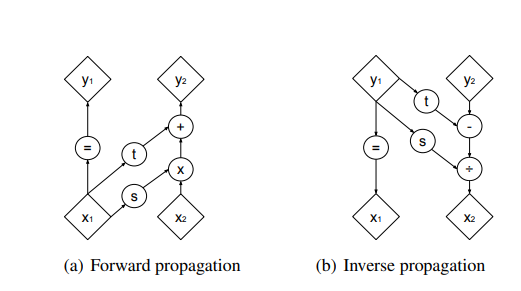

Nadopunite predloženi razred `AffineCouplingLayer` s prikladnom funkcionalnošću.
Afino miješanje transformira samo polovicu ulaznog tezora $\mathbf{x}_{m:d}$, dok druga polovica $\mathbf{x}_{:m}$ ostaje nepromijenjena.
Modul miješanja `net` predviđa parametre miješanja `log_s` i `t` iz polovice ulaznog tenzora $\mathbf{x}_{:m}$.

$$
\mathbf{z}_{:m} = \mathbf{x}_{:m}
$$
$$
\mathbf{z}_{m:d} = \exp(\ln\mathbf{s}) \odot \mathbf{x}_{m:d} + \mathbf{t}, \quad \ln s, t = net(\mathbf{x}_{:m})
$$
$$
\text{Jacobijan} = \begin{bmatrix} \mathbf{I} & \mathbf{0} \\ \frac{\partial \mathbf{z}_{m:d}}{\partial \mathbf{x}_{:m}} & \text{diag}(\exp(\ln \mathbf{s})) \end{bmatrix}
$$
$$
\text{det(Jacobijan)} = det(\text{diag}(\exp(\ln \mathbf{s})))
$$
$$
\text{det(Jacobijan)} = 1 \cdot \prod_{i} \exp(\text{log(s}_i))
$$
$$
\text{log(det(Jacobijan))} = \sum_{i} \text{log(s}_i)
$$

In [ ]:
class AffineCouplingLayer(_Bijection):
    def __init__(self, net:nn.Module, m: int = None):
        super(AffineCouplingLayer, self).__init__()
        self.net = net
        self.m = m

    def forward(self, x): # NxD
        if self.m is None:
          m = int(0.5 * x.shape[0])

        x1,x2 = torch.chunk(x, 2, dim=1)

        log_s, t = self.net(x1)
        z2 = torch.exp(log_s).mul(x2) + t

        log_det = log_s.sum(dim=1)
        z = torch.cat((x1, z2), dim=1)

        return z , log_det # NxD , N

    def inverse(self, y): # NxD
        if self.m is None:
          m = int(0.5 * y.shape[0])

        x =  y

        x1,x2 = torch.chunk(x, 2, dim=1)
        log_s, t = self.net(x1)

        x2 = (x2 - t).mul(torch.exp(-log_s))
        x = torch.cat((x1,x2),dim=1)

        return x # NxD

**Zadatak 6.:** Zamislimo situaciju gdje slijedno primjenjujemo više coupling slojeva. Možemo primijetiti da će se miješati samo jedna polovica tenzora. Kako bismo osigurali da se miješaju obje polovice ulaznog tenzora, uvodimo transformaciju `SwitchSides` koju ćemo primijeniti nakon svakog coupling sloja.
Na taj način osiguravamo da miješanje provodimo naizmjenično na dvjema polovicama ulaznog tenzora. \
Tenzor dijelimo po dimenziji značajki. Dovršite implementaciju razreda `SwitchSides` tako da dijeli ulazni tenzor na dva dijela po dimenziji značajki i zamjenjuje im strane. Možete iskoristiti funkcije [chunk](https://pytorch.org/docs/stable/generated/torch.chunk.html) i [cat](https://pytorch.org/docs/stable/generated/torch.cat.html).

In [ ]:
class SwitchSides(_Bijection):
    def forward(self, x: Tuple[Tensor, Tensor]) -> Union[Tensor, int]:
        x1,x2 = torch.chunk(x, 2, dim=1)
        y = torch.cat((x2, x1), dim=1)
        return y ,0

    def inverse(self, z: Tensor) -> Tensor:
        z1,z2 = torch.chunk(z, 2, dim=1)
        x = torch.cat((z2, z1), dim=1)
        return x

**Zadatak 7.:**U nastavku je dan razred `SimpleTransform` kojeg ćemo koristiti kao modul afinog miješanja u coupling sloju. Primijetite da će primjerci tog razreda biti atributi `net` razreda `AffineCouplingLayer`.\
Dovršite implementaciju tako da `model` bude potpuno povezani modul sljedeće arhitekture:

`fc(dim, internal_dim) -> relu -> fc(internal_dim, internal_dim) -> relu -> fc(internal_dim, 2*dim)`.

Dimenziju skrivenog sloja potpuno povezanog modula određujemo parametrom `inflate_coef`. \


Inicijalizirajte parametre modula miješanja tako da modul provodi transformaciju koja je jednaka identitetu. \

In [ ]:
class SimpleTransform(nn.Module):
    def __init__(self, dim, inflate_coef=1):
        super(SimpleTransform, self).__init__()
        self.dim = dim
        internal_dim = int(dim * inflate_coef)
        self.model = nn.Sequential(
            nn.Linear(self.dim, internal_dim),
            nn.ReLU(),
            nn.Linear(internal_dim, internal_dim),
            nn.ReLU(),
            nn.Linear(internal_dim, 2*self.dim)
        )
        # initialize self.model to identity
        nn.init.zeros_(self.model[-1].weight)
        nn.init.zeros_(self.model[-1].bias)

    def forward(self, x):
        out = self.model(x)
        log_s, t = torch.chunk(out, dim=1, chunks=2)
        return log_s, t


In [ ]:
class SimpleRealNVP(NormalizingFlow):
    def __init__(self, input_dim, num_steps=2, device='cpu'):
        transforms = nn.Sequential()
        for i in range(num_steps):
            transforms.append(AffineCouplingLayer(SimpleTransform(input_dim//2)))
            if i != num_steps - 1:
                transforms.append(SwitchSides())
        super(SimpleRealNVP, self).__init__(transforms, input_dim)


Tok možemo naučiti na način kako slijedi:

In [ ]:
# flow = SimpleRealNVP(2, num_steps=7)
# optim = torch.optim.SGD(flow.parameters(), lr=1e-2, nesterov=True, momentum=0.9)

# for iter in range(2000):
#     optim.zero_grad()
#     log_px = flow.log_prob(D)
#     loss = - (log_px).mean()
#     total_loss = loss
#     total_loss.backward()
#     optim.step()
#     if iter % 100 == 0:
#         print(f"Iter {iter+1}: Loss:{loss.item()}")

In [ ]:
print((flow.inverse(flow(D)[0]) - D).sum())
assert (flow.inverse(flow(D)[0]) - D).sum() < 1e-4

tensor(0., grad_fn=<SumBackward0>)


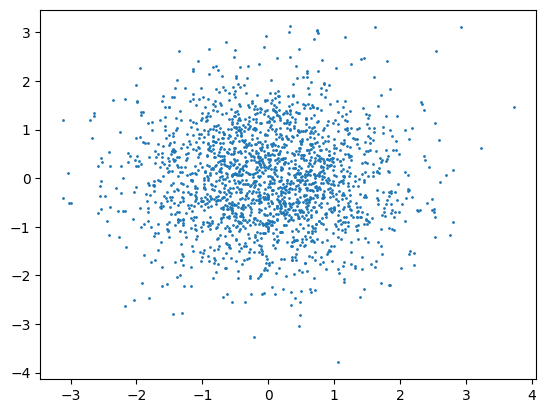

In [ ]:
X_ = flow.sample(2000, 1).detach()
plt.scatter(X_[:, 0], X_[:, 1], 1)
plt.show()

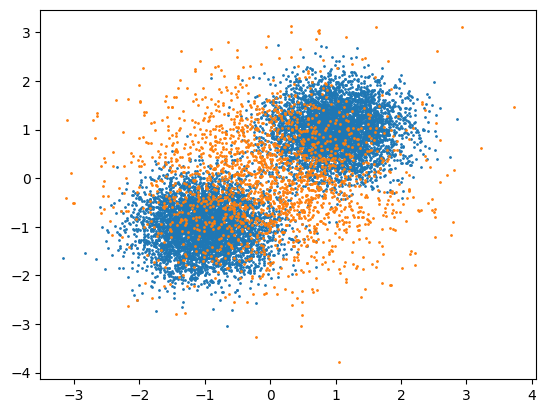

In [ ]:
plt.clf()
plt.scatter(D[:, 0], D[:, 1], 1)
plt.scatter(X_[:, 0], X_[:, 1], 1)

Kao što vidite, kapacitetniji tok uspijeva dobro aproksimirati dani skup podataka.

## Modeliranje slika normalizirajućim tokom

Naš sljedeći zadatak je modelirati distribuciju slika s normalizirajućim tokom. Slike možemo prestaviti diskretnim tenzorom $\mathbf{x} \in [0, 255]^{C \times H \times W}$. Prisjetimo se da smo normalizirajući tok definirali za kontinuirane slučajne varijable. Stoga, potrebno je transfrormirati skup podataka u kontinuiranu domenu pomoću zašumljivanja:

$$
\mathbf{y} = \mathbf{x} + \mathbf{u}, \quad \mathbf{u} \sim \mathrm{U}[0, 1)
$$
U prestavlja uniformnu razdiobu. Sada, naš model uči modelirati zašumljenu sliku. Više o dekvantizaciji zašumljivanjem možete pronaći [ovdje](https://arxiv.org/pdf/1511.01844.pdf).

MNIST je skup jednostavnih slika pa ćemo se poslužiti sljedećim pojednostavljenjem. Sliku ćemo ispeglati u vektor i normalizirajućim tokom učiti takvu reprezentaciju slike.

U nastavku je dan kod za pripremanje skupa slika.

In [ ]:
from torchvision.datasets import MNIST
import torchvision.transforms as tf
from torch.utils.data import DataLoader, Subset

In [ ]:
train_ds = MNIST('.', train=True, download=True, transform=tf.Compose([tf.Resize(14), tf.ToTensor()]))
test_ds = MNIST('.', train=False, download=True, transform=tf.Compose([tf.Resize(14), tf.ToTensor()]))

selected_number = 0

indices = [r[0] for r in list(filter(lambda x: x[1] == selected_number ,[(i, train_ds[i][1]) for i in range(len(train_ds))]))]
train_ds = Subset(train_ds, indices)

indices = [r[0] for r in list(filter(lambda x: x[1] == selected_number ,[(i, test_ds[i][1]) for i in range(len(test_ds))]))]
test_ds = Subset(test_ds, indices)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=128, shuffle=False)

In [ ]:
def plot_mnist(samples, num_row, num_col,savepath=None):
    assert len(samples) ==  num_row * num_col
    fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
    for i in range(len(samples)):
        ax = axes[i//num_col, i%num_col]
        ax.imshow(samples[i], cmap='gray')
    if savepath is not None:
      plt.savefig(savepath)
    plt.tight_layout()
    plt.show()

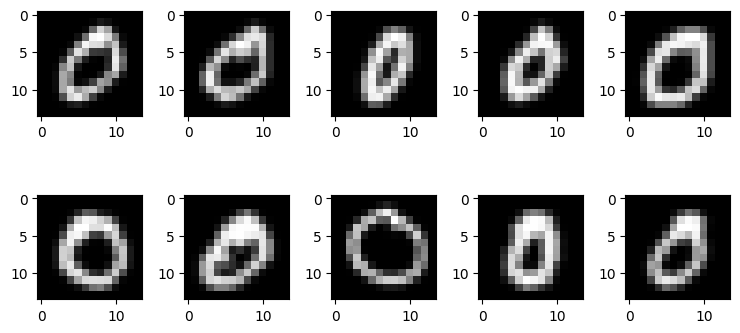

In [ ]:
samples = [train_ds[i][0][0] for i in range(10)]
plot_mnist(samples, 2, 5)

**Zadatak 8.:** Predložite arhitekturu toka koji će moći naučiti distribuciju vektoriziranih slika. Predlažemo koristiti rezidualni blok sljedeće arhitekture.

`fc(dim, dim) -> BN -> relu -> fc(dim, dim) -> relu`

Potrebno je dodati rezidualnu vezu od ulaza u rezidualni blok do latentne reprezentacije prije posljednje zglobnice.
Dovršite implementaciju i validirajte utjecaj batchnorma na proces učenja i konačne rezultate.

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, dim, use_bn=False):
        super(ResidualBlock, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(dim, dim),
            nn.BatchNorm1d(dim, dim) if use_bn else nn.Identity(),
            nn.ReLU(),
            nn.Linear(dim, dim),
        )
        self.f_relu = nn.ReLU()

    def forward(self, x):
        identity = x
        out = self.layers(x)
        out = out + identity
        return self.f_relu(out)

**Zadatak 9.:** Po uzoru na razred `SimpleTransform` dovršite implementaciju razreda `SimpleResidualTransform` čiji se modul miješanja sastoji od rezidualnih blokova. Predlažemo sljedeću arhitekturu:

`fc(dim, internal_dim) -> relu -> res_block(internal_dim, internal_dim) -> fc(internal_dim, 2*dim)`

Eksperimentirajte s brojem rezidualnih blokova. Kako broj rezidualnih blokova utječe na rezultate?

In [ ]:
class SimpleResidualTransform(nn.Module):
    def __init__(self, dim, inflate_coef=1, use_bn = False):
        super(SimpleResidualTransform, self).__init__()
        self.dim = dim
        internal_dim = int(dim * inflate_coef)
        self.model = nn.Sequential(
            nn.Linear(self.dim, internal_dim),
            nn.ReLU(),
            ResidualBlock(internal_dim, use_bn = use_bn),
            nn.Linear(internal_dim, 2*self.dim)
        )

    def forward(self, x):
        out = self.model(x)
        log_s, t = torch.chunk(out, dim=1, chunks=2)
        return log_s, t

**Zadatak 10.:** Dovršte implementaciju razreda `RealNVP` po uzoru na `SimpleRealNVP`. `RealNVP` treba koristiti `SimpleResidualTransform` umjesto `SimpleTransform` kao modul miješanja.

In [ ]:
class RealNVP(NormalizingFlow):
    def __init__(self, input_dim, num_steps=2, device='cpu', use_bn = False):
        transforms = nn.Sequential()
        for i in range(num_steps):
            transforms.append(AffineCouplingLayer(SimpleResidualTransform(input_dim//2, use_bn = use_bn)))
            if i != num_steps - 1:
              transforms.append(SwitchSides())
        super(RealNVP, self).__init__(transforms, input_dim, device)

U nastavku je kod za učenje toka.

Obratite pozornost na to da izglednost slike prikazujemo u bitovima po dimenziji (BPD). Podsjetite se što ta mjera predstavlja i kako ju računamo.

In [ ]:
import os

device = 'cuda'
use_bn =  False
epochs = 1000
bits = 8
visualize_every = 100
num_residual_layers = 30
savedir = os.path.join('results',f'use_bn_{use_bn}', f'num_residual_layers_{num_residual_layers}')
if not os.path.exists(savedir):
    os.makedirs(savedir)

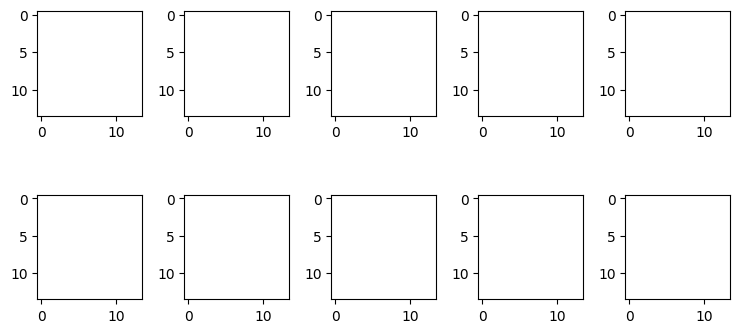

Epoch 1: Train Loss:1298.2243132895612 Val BPD: 9.414706230163574


In [ ]:
flow = RealNVP(14*14, num_steps=num_residual_layers, device=device, use_bn=use_bn).to(device)
optim = torch.optim.AdamW(flow.parameters(), lr=1e-5)

for ep in range(epochs):
    total_loss = 0.
    iters = 0
    for x, _ in train_loader:
        x = (x * 255).long()
        u = torch.rand_like(x.float())
        x = x + u
        x = x / (2 ** bits)
        x = x.flatten(start_dim=1)
        optim.zero_grad()
        log_px = flow.log_prob(x.to(device)) - np.log((2 ** bits)) * (14 * 14)
        loss = - (log_px).mean()
        loss.backward()
        optim.step()
        iters += 1
        total_loss += loss.item()
    if ep % visualize_every == 0 or ep == epochs -1:
        with torch.no_grad():
            val_iters = 0
            total_bpd = 0.
            for x, _ in test_loader:
                x = (x * 255).long()
                u = torch.rand_like(x.float())
                x = x + u
                x = x / (2 ** bits)
                x = x.flatten(start_dim=1)
                log_px = flow.log_prob(x.to(device)) - np.log((2 ** bits)) * (14 * 14)
                bpd = -(log_px).mean().cpu() / (np.log(2) * (14 * 14))
                total_bpd += bpd
                val_iters += 1
        samples = flow.sample(10).detach().cpu()
        samples = torch.unflatten(samples, dim=1, sizes=(14, 14)).unsqueeze(1)

        savepath =  os.path.join(savedir,f'epoch_{ep}.png')
        plot_mnist(samples[:, 0], 2, 5,savepath)

        print(f"Epoch {ep+1}: Train Loss:{total_loss / iters} Val BPD: {total_bpd / val_iters}")

In [ ]:
samples = flow.sample(10).detach().cpu()
samples = torch.unflatten(samples, dim=1, sizes=(14, 14)).unsqueeze(1)
plot_mnist(samples[:,0], 2, 5)

In [ ]:
torch.save(flow.state_dict(), os.path.join(savedir,'normalizing_flow_weights.pth'))

## Bonus zadatak

Predložite implementaciju konvolucijskog normalizirajućeg toka.